In [1]:
print("Installing necessary libraries...")
!pip install astropy lightkurve scipy --quiet

Installing necessary libraries...


In [5]:
# ==============================================================
# DATA PREPROCESSING PIPELINE FOR CNN TRAINING (JUPYTER VERSION)
# ==============================================================
# Compatible with Jupyter Notebook environment (no "__main__" guard)
# ==============================================================

import os
import numpy as np
from astropy.io import fits
import lightkurve as lk
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import multiprocessing

# ==============================================================
# CONFIGURATION
# ==============================================================
PARENT_DIR = "Dataset2"   # <-- CHANGE THIS
PLANET_DIR = os.path.join(PARENT_DIR, "Candidates")
FALSE_POS_DIR = os.path.join(PARENT_DIR, "false_positives")

IMAGE_SIZE = 64
FLUX_COLUMN = "FLUX"
TIME_COLUMN = "TIME"
MIN_POINTS = 100
PHASE_WINDOW = 0.1

OUTPUT_X = "X.npy"
OUTPUT_Y = "y.npy"

# ==============================================================
# SINGLE FILE PROCESSING
# ==============================================================
def process_fits_to_image(file_path, image_size=IMAGE_SIZE):
    """Process one FITS file -> (64, 64) CNN image."""
    try:
        # --- Load FITS data ---
        with fits.open(file_path, mode="readonly") as hdul:
            data = hdul[1].data
            time = data[TIME_COLUMN]
            flux = data[FLUX_COLUMN]

        lc = lk.LightCurve(time=time, flux=flux).remove_nans()
        if len(lc) < MIN_POINTS:
            return None

        # --- Flatten & smooth ---
        lc_flat = lc.normalize().flatten(window_length=401)
        if len(lc_flat.flux) > 51:
            lc_flat.flux = savgol_filter(lc_flat.flux, 51, 3)

        # --- Period detection ---
        periodogram = lc_flat.to_periodogram(minimum_period=0.5, maximum_period=30)
        best_period = periodogram.period_at_max_power

        # --- Fold & center ---
        lc_folded_pre_center = lc_flat.fold(period=best_period)
        transit_midpoint_time = lc_folded_pre_center.time_original[np.argmin(lc_folded_pre_center.flux)]
        lc_folded = lc_flat.fold(period=best_period, epoch_time=transit_midpoint_time)

        # --- Transit window ---
        phase_mask = (lc_folded.phase > -PHASE_WINDOW) & (lc_folded.phase < PHASE_WINDOW)
        lc_windowed = lc_folded[phase_mask]
        if len(lc_windowed) < 10:
            return None

        # --- Interpolate to fixed length ---
        phase = lc_windowed.phase.value
        flux_values = lc_windowed.flux.value
        sorted_idx = np.argsort(phase)
        phase, flux_values = phase[sorted_idx], flux_values[sorted_idx]

        interp_fn = interp1d(phase, flux_values, kind='linear', fill_value="extrapolate")
        phase_uniform = np.linspace(-PHASE_WINDOW, PHASE_WINDOW, image_size)
        flux_interp = interp_fn(phase_uniform)

        # --- Normalize ---
        flux_range = np.max(flux_interp) - np.min(flux_interp)
        if flux_range <= 0 or not np.isfinite(flux_range):
            return None

        normalized_flux = (flux_interp - np.min(flux_interp)) / flux_range

        # --- Create 2D CNN image ---
        image = np.tile(normalized_flux, (image_size, 1))  # Shape: (64, 64)
        return image

    except Exception:
        return None

# ==============================================================
# BATCH PROCESSING
# ==============================================================
def build_dataset(planet_dir, falsepos_dir, n_workers=4, use_multiprocessing=True):
    """Processes all FITS files -> (X, y) arrays."""
    planet_files = [os.path.join(planet_dir, f) for f in os.listdir(planet_dir) if f.endswith(".fits")]
    false_files = [os.path.join(falsepos_dir, f) for f in os.listdir(falsepos_dir) if f.endswith(".fits")]

    all_files = [(f, 1) for f in planet_files] + [(f, 0) for f in false_files]
    print(f"Found {len(planet_files)} planet files and {len(false_files)} false positive files.")

    X, y = [], []
    skipped = 0

    if use_multiprocessing and len(all_files) > 1:
        # In Jupyter, "spawn" start method ensures compatibility
        multiprocessing.set_start_method("spawn", force=True)
        with ProcessPoolExecutor(max_workers=n_workers) as executor:
            futures = {executor.submit(process_fits_to_image, path): label for path, label in all_files}
            for future in tqdm(as_completed(futures), total=len(futures), desc="Processing FITS files"):
                img = future.result()
                if img is not None and img.shape == (IMAGE_SIZE, IMAGE_SIZE):
                    X.append(img)
                    y.append(futures[future])
                else:
                    skipped += 1
    else:
        # Sequential fallback (safe for debugging)
        for path, label in tqdm(all_files, desc="Processing FITS files (sequential)"):
            img = process_fits_to_image(path)
            if img is not None and img.shape == (IMAGE_SIZE, IMAGE_SIZE):
                X.append(img)
                y.append(label)
            else:
                skipped += 1

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    print(f"✅ Completed: {len(X)} usable samples out of {len(all_files)} files.")
    print(f"🚫 Skipped: {skipped} files due to invalid or incomplete data.")
    return X, y

# ==============================================================
# EXECUTION (for Jupyter)
# ==============================================================
# Just run this cell directly:
X, y = build_dataset(PLANET_DIR, FALSE_POS_DIR, n_workers=4, use_multiprocessing=False)

print(f"Final dataset shape: X={X.shape}, y={y.shape}")
print("Saving dataset...")
np.save(OUTPUT_X, X)
np.save(OUTPUT_Y, y)
print(f"✅ Saved: {OUTPUT_X}, {OUTPUT_Y}")


Found 5033 planet files and 3932 false positive files.


Processing FITS files (sequential): 100%|██████████████████████████████████████████| 8965/8965 [16:57<00:00,  8.81it/s]


✅ Completed: 8963 usable samples out of 8965 files.
🚫 Skipped: 2 files due to invalid or incomplete data.
Final dataset shape: X=(8963, 64, 64), y=(8963,)
Saving dataset...
✅ Saved: X.npy, y.npy


In [ ]:
import numpy as np
X = np.load("X.npy")
y = np.load("y.npy")
print(X.shape, y.shape)


C:\Users\Md Sahanawaj Karim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

🚀 Training Baseline_CNN ...
Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.5099 - loss: 0.8075 - val_accuracy: 0.5410 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.5393 - loss: 0.7273 - val_accuracy: 0.5349 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.5316 - loss: 0.7200 - val_accuracy: 0.5611 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.5546 - loss: 0.7011 - val_accuracy: 0.5644 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5425 - loss: 0.6971 - val_accuracy: 0.5633 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/

🔍 Optimal threshold for Baseline_CNN: 0.482
✅ Baseline_CNN - Acc: 0.564, Prec: 0.563, Rec: 0.999, F1: 0.720, AUC: 0.517

🚀 Training MobileNetV3 ...
Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5476 - loss: 0.7012 - val_accuracy: 0.5616 - val_loss: 0.6855 - learning_rate: 0.0010
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5564 - loss: 0.6895 - val_accuracy: 0.5616 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.5721 - loss: 0.6829 - val_accuracy: 0.5616 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5560 - loss: 0.6881 - val_accuracy: 0.5616 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5627 - loss: 0.6866 - val_accuracy: 0.5616 - val_loss: 0.6855 - learning_rate: 5.0000e-04
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5599 - los

🔍 Optimal threshold for MobileNetV3: 0.561
✅ MobileNetV3 - Acc: 0.562, Prec: 0.562, Rec: 1.000, F1: 0.720, AUC: 0.518

🚀 Training ResNet50V2 ...
Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 68s 139ms/step - accuracy: 0.5340 - loss: 0.7013 - val_accuracy: 0.5616 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 65s 146ms/step - accuracy: 0.5490 - loss: 0.6893 - val_accuracy: 0.5616 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step - accuracy: 0.5591 - loss: 0.6868 - val_accuracy: 0.5616 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 69s 154ms/step - accuracy: 0.5656 - loss: 0.6862 - val_accuracy: 0.5616 - val_loss: 0.6856 - learning_rate: 0.0010
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 65s 145ms/step - accuracy: 0.5761 - loss: 0.6825 - val_accuracy: 0.5616 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 64s 143ms/step - accuracy: 0.5597 - loss

🔍 Optimal threshold for ResNet50V2: 0.554
✅ ResNet50V2 - Acc: 0.565, Prec: 0.564, Rec: 0.999, F1: 0.721, AUC: 0.515

🚀 Training EfficientNetB0 ...
Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.5376 - loss: 0.6990 - val_accuracy: 0.5616 - val_loss: 0.6855 - learning_rate: 0.0010
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.5612 - loss: 0.6871 - val_accuracy: 0.5616 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.5568 - loss: 0.6869 - val_accuracy: 0.5616 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5602 - loss: 0.6872 - val_accuracy: 0.5616 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.5688 - loss: 0.6847 - val_accuracy: 0.5616 - val_loss: 0.6855 - learning_rate: 5.0000e-04
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.5569 - loss

🔍 Optimal threshold for EfficientNetB0: 0.561
✅ EfficientNetB0 - Acc: 0.562, Prec: 0.562, Rec: 1.000, F1: 0.719, AUC: 0.504

📊 Final Comparison:
            Model  Accuracy  Precision    Recall        F1       AUC  \
2      ResNet50V2  0.564975   0.563585  0.999007  0.720630  0.515256   
0    Baseline_CNN  0.564417   0.563270  0.999007  0.720372  0.517069   
1     MobileNetV3  0.562186   0.561942  1.000000  0.719543  0.518453   
3  EfficientNetB0  0.561629   0.561629  1.000000  0.719286  0.504183   

   Best_Threshold  
2        0.553548  
0        0.481912  
1        0.560704  
3        0.560745  


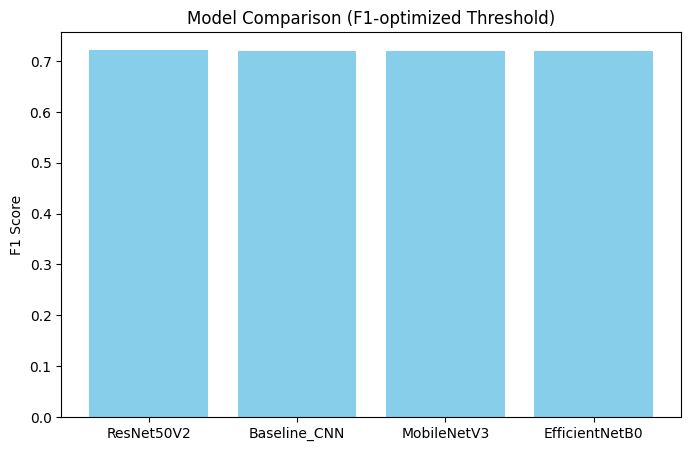

In [2]:
# ==============================================================
# MULTI-MODEL CNN TRAINING + THRESHOLD OPTIMIZATION
# ==============================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os

# ==============================================================
# 0. SETUP
# ==============================================================
SAVE_DIR = "Dataset2_output_multimodel"
os.makedirs(SAVE_DIR, exist_ok=True)

# ==============================================================
# 1. LOAD DATA
# ==============================================================
X = np.load("X.npy")
y = np.load("y.npy")

# Normalize & expand
X = X.astype("float32") / 255.0
X = X[..., np.newaxis]              # (N,64,64,1)
X = np.repeat(X, 3, axis=-1)        # Make 3-channel for pretrained CNNs

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================================================
# 2. DATA AUGMENTATION
# ==============================================================
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(height_factor=0.0, width_factor=0.05),
    layers.RandomZoom(height_factor=0.0, width_factor=0.05)
])

# ==============================================================
# 3. MODEL BUILDERS
# ==============================================================

def build_baseline(input_shape=(64, 64, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])
    return model


def build_mobilenetv3(input_shape=(64,64,3)):
    base = tf.keras.applications.MobileNetV3Small(include_top=False, weights='imagenet',
                                                  input_shape=input_shape, pooling='avg')
    base.trainable = False
    x = layers.Dense(128, activation='relu')(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=base.input, outputs=out)


def build_resnet50v2(input_shape=(64,64,3)):
    base = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                            input_shape=input_shape, pooling='avg')
    base.trainable = False
    x = layers.Dense(128, activation='relu')(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=base.input, outputs=out)


def build_efficientnetb0(input_shape=(64,64,3)):
    base = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet',
                                                input_shape=input_shape, pooling='avg')
    base.trainable = False
    x = layers.Dense(128, activation='relu')(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=base.input, outputs=out)


# ==============================================================
# 4. TRAIN & EVALUATE FUNCTION (with threshold optimization)
# ==============================================================

def find_optimal_threshold(y_true, y_prob, method='f1'):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    if method == 'youden':
        # Youden’s J statistic: maximize (recall + specificity - 1)
        fpr = 1 - precision  # proxy for false positive rate
        j_scores = recall - fpr
        idx = np.argmax(j_scores)
    else:
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        idx = np.argmax(f1)
    return thresholds[idx] if idx < len(thresholds) else 0.5


def train_and_evaluate(model, name):
    print(f"\n🚀 Training {name} ...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        data_aug(X_train, training=True), y_train,
        validation_data=(X_test, y_test),
        epochs=15, batch_size=16,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Predict probabilities
    y_pred_prob = model.predict(X_test).flatten()

    # Threshold optimization
    best_thr = find_optimal_threshold(y_test, y_pred_prob, method='f1')
    print(f"🔍 Optimal threshold for {name}: {best_thr:.3f}")

    # Apply threshold
    y_pred = (y_pred_prob >= best_thr).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    cm = confusion_matrix(y_test, y_pred)
    joblib.dump(cm, os.path.join(SAVE_DIR, f"{name}_cm.pkl"))

    print(f"✅ {name} - Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")

    return {
        "Model": name, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1": f1, "AUC": auc,
        "Best_Threshold": best_thr
    }

# ==============================================================
# 5. RUN ALL MODELS
# ==============================================================
models_to_train = {
    "Baseline_CNN": build_baseline(),
    "MobileNetV3": build_mobilenetv3(),
    "ResNet50V2": build_resnet50v2(),
    "EfficientNetB0": build_efficientnetb0()
}

results = []
for name, mdl in models_to_train.items():
    res = train_and_evaluate(mdl, name)
    results.append(res)
    mdl.save(os.path.join(SAVE_DIR, f"{name}.h5"))

# ==============================================================
# 6. AGGREGATE RESULTS
# ==============================================================
df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
df.to_csv(os.path.join(SAVE_DIR, "model_comparison.csv"), index=False)

print("\n📊 Final Comparison:")
print(df)

# Plot F1-score comparison
plt.figure(figsize=(8,5))
plt.bar(df["Model"], df["F1"], color="skyblue")
plt.ylabel("F1 Score")
plt.title("Model Comparison (F1-optimized Threshold)")
plt.savefig(os.path.join(SAVE_DIR, "model_f1_comparison.png"))
plt.show()
